In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from functools import partial
from random import uniform
rc('animation', html='jshtml')

Рассмотрим динамические эпистемические задачи для 2 агентов, где возможные миры представляют собой точки в двумерном пространстве. Некоторые области будут изначально помечены как невозможные. Для этого используются прямоугольники со сторонами, параллельными осям $x$ и $y$.

# Генерация цвета

Для демонстрации, мы можем думать о координатах не как точках на карте, а как о 2 из 3 значений, которые используются для представления цветов. Например, красный и зеленый в RGB или насыщенность и значение в HSV. Посмотрим, как в таком случае будет выглядеть пространство.

In [2]:
def arr_create(upper_left, upper_right, lower_left, lower_right):
    arr = np.linspace(np.linspace(lower_left, lower_right, arrwidth),
                      np.linspace(upper_left, upper_right, arrwidth), arrheight, dtype=float)
    return arr[:, :, None]

arrwidth = 256
arrheight = 256

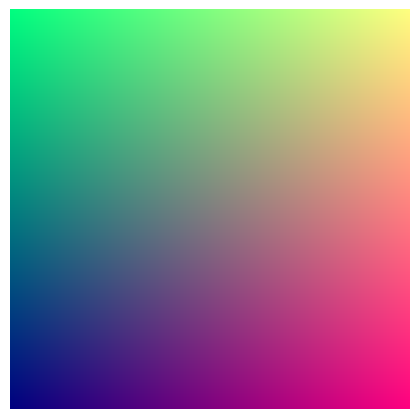

In [3]:
# RGB
fig, ax = plt.subplots(figsize=(4, 4))

r = arr_create(0,   1, 0,   1)
g = arr_create(1,   1,   0, 0)
b = arr_create(0.5, 0.5, 0.5,   0.5)

img = np.concatenate([r, g, b], axis=2)

ax.imshow(img, origin="lower")
ax.axis("off")

fig.subplots_adjust(bottom = 0)
fig.subplots_adjust(top = 1)
fig.subplots_adjust(right = 1)
fig.subplots_adjust(left = 0)

plt.savefig('rgb_colors.jpg')
plt.show()

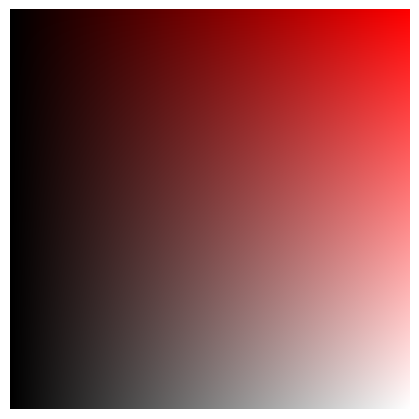

In [4]:
# HSV
fig, ax = plt.subplots(figsize=(4, 4))

hue = np.ones((arrheight, arrwidth, 1), dtype=float)
saturation = arr_create(1, 1, 0, 0)
value = arr_create(0, 1, 0, 1)

img = matplotlib.colors.hsv_to_rgb(np.concatenate([hue, saturation, value], axis=2))

ax.imshow(img, origin='lower', aspect='auto')
ax.axis('off')

fig.subplots_adjust(bottom = 0)
fig.subplots_adjust(top = 1)
fig.subplots_adjust(right = 1)
fig.subplots_adjust(left = 0)

plt.savefig('hsv_colors.jpg')
plt.show()

# День рождения Шерил

Классическую задачу о дне рождении Шерил можно представить в виде задачи на плоскости.

In [5]:
# Cheryl's birthday example
num_x, num_y = 4, 6
eps = {'x': 1.5 / num_y, 'y': 1.5 / num_x}
gl_bounds = {'x': [0, 1], 'y': [0, 1]} # global bounds
true_coords = {'x': 2.5 / num_x, 'y': 2.5 / num_y}

# store rectangles as [x_min, x_max, y_min, y_max]
rects = np.array([[0, 1 / num_x, 0, 1 / num_y],
                  [0, 1 / num_x, 3 / num_y, 5 / num_y],
                  [1 / num_x, 2 / num_x, 0, 3 / num_y],
                  [1 / num_x, 2 / num_x, 5 / num_y, 1],
                  [2 / num_x, 3 / num_x, 1 / num_y, 2 / num_y],
                  [2 / num_x, 3 / num_x, 3 / num_y, 1],
                  [3 / num_x, 1, 2 / num_y, 3 / num_y],
                  [3 / num_x, 1, 4 / num_y, 1]])

# limit to the bounded area
rects[:, :2] = np.clip(rects[:, :2], gl_bounds['x'][0], gl_bounds['x'][1])
rects[:, 2:] = np.clip(rects[:, 2:], gl_bounds['y'][0], gl_bounds['y'][1])

In [6]:
# # another example
# eps = {'x': 0.4, 'y': 0.4}
# true_coords = {'x': 0.4, 'y': 0.6}
# rects = np.array([[0, 0.5, 0, 0.5],
#                     [0, 1, 0.75, 1],
#                     [0.8, 1, 0, 0.2]])

In [7]:
grid = {'x': np.unique(np.concatenate([gl_bounds['x'], rects[:, 0], rects[:, 1]])), # np.unique sorts the values
        'y': np.unique(np.concatenate([gl_bounds['y'], rects[:, 2], rects[:, 3]]))}

# for animating we'll store on which step the cell became impossible
possible_cells = np.full((grid['y'].shape[0] - 1, grid['x'].shape[0] - 1), -1, dtype=int)

def mark_area_impossible(step, grid, possible_cells, rect):
    x_id = np.where(np.isclose(grid['x'], rect[0]))[0][0]
    y_id = np.where(np.isclose(grid['y'], rect[2]))[0][0]
    st_x_id = x_id
    has_changed = False
    while grid['y'][y_id] < rect[3]:
        while grid['x'][x_id] < rect[1]:
            if possible_cells[y_id, x_id] == -1:
                has_changed = True
                possible_cells[y_id, x_id] = step
            x_id += 1
        x_id = st_x_id
        y_id += 1
    return has_changed

for rect in rects:
    mark_area_impossible(0, grid, possible_cells, rect)
possible_cells

array([[ 0,  0, -1, -1],
       [-1,  0,  0, -1],
       [-1,  0, -1,  0],
       [ 0, -1,  0, -1],
       [ 0, -1,  0,  0],
       [-1,  0,  0,  0]])

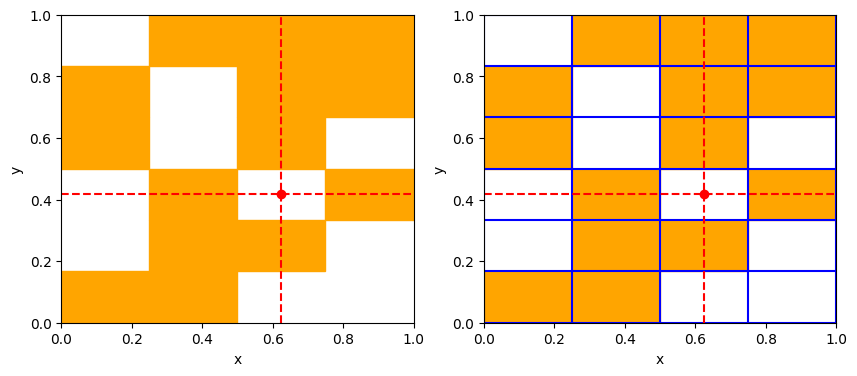

In [8]:
# draw grid, impossible areas and true coordinates
def draw(frame, ax, grid, possible_cells, true_coords, gl_bounds, draw_grid=True, img=None):
    if img is not None:
        ax.imshow(img, extent=[gl_bounds['x'][0], gl_bounds['x'][1], gl_bounds['y'][0], gl_bounds['y'][1]])
    if draw_grid:
        ax.vlines(grid['x'], gl_bounds['y'][0], gl_bounds['y'][1], colors='blue')
        ax.hlines(grid['y'], gl_bounds['x'][0], gl_bounds['x'][1], colors='blue')

    alpha = 1
    ax.plot(true_coords['x'], true_coords['y'], marker='o', color='red', alpha=alpha)
    ax.vlines(true_coords['x'], 0, 1, colors='red', linestyle='dashed', alpha=alpha)
    ax.hlines(true_coords['y'], 0, 1, colors='red', linestyle='dashed', alpha=alpha)

    for row_id in range(possible_cells.shape[0]):
        for col_id in range(possible_cells.shape[1]):
            if possible_cells[row_id, col_id] == frame:
                x = [grid['x'][col_id], grid['x'][col_id], grid['x'][col_id + 1], grid['x'][col_id + 1]]
                y = [grid['y'][row_id], grid['y'][row_id + 1], grid['y'][row_id + 1], grid['y'][row_id]]
                ax.fill(x, y, color='orange')

    ax.set(xlim=gl_bounds['x'], ylim=gl_bounds['y'])
    ax.set_xlabel('x')
    ax.set_ylabel('y')

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
draw(0, axs[0], grid, possible_cells, true_coords, gl_bounds, draw_grid=False)
draw(0, axs[1], grid, possible_cells, true_coords, gl_bounds)

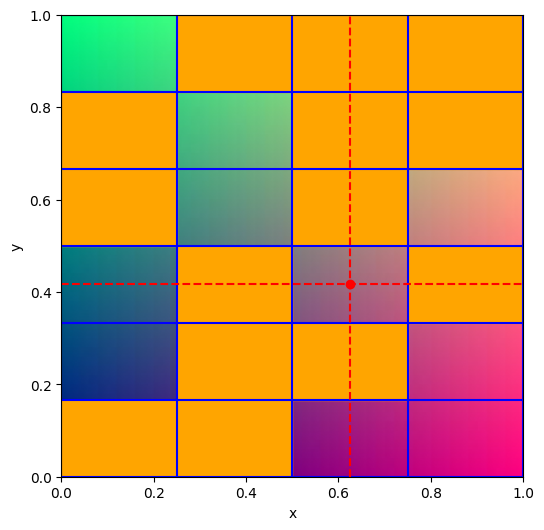

In [9]:
img = plt.imread('rgb_colors.jpg')
fig, ax = plt.subplots(figsize=(6, 6))
draw(0, ax, grid, possible_cells, true_coords, gl_bounds, img=img)

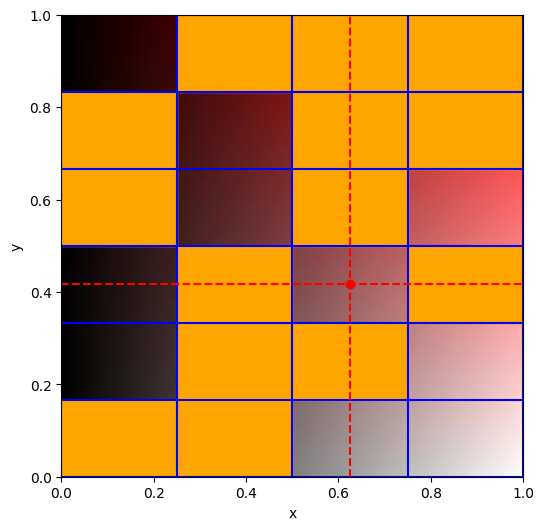

In [10]:
img = plt.imread('hsv_colors.jpg')
fig, ax = plt.subplots(figsize=(6, 6))
draw(0, ax, grid, possible_cells, true_coords, gl_bounds, img=img)

In [11]:
def free_segment_length(coord, axis, grid, possible_cells, gl_bounds):
    # coord: float in [0, 1] - coord in axis
    # axis: 'x' or 'y'
    other_axis = 'x' if axis == 'y' else 'y'
    cell_id = np.searchsorted(grid[axis][:-1], coord, side='right') - 1 # index of corresponding column/row of cells
    first_avail, last_avail = None, None
    oa_idx = 0 if axis == 'x' else 1 # other axis id for possible_cells
    for i in range(possible_cells.shape[oa_idx]):
        row_id, col_id = cell_id, i
        if axis == 'x':
            row_id, col_id = col_id, row_id
        if possible_cells[row_id, col_id] == -1:
            first_avail = i
            break
    for i in range(possible_cells.shape[oa_idx] - 1, -1, -1):
        row_id, col_id = cell_id, i
        if axis == 'x':
            row_id, col_id = col_id, row_id
        if possible_cells[row_id, col_id] == -1:
            last_avail = i
            break
    if first_avail is None or last_avail is None:
        return False # no possible cells for that coordinate
    return grid[other_axis][last_avail + 1] - grid[other_axis][first_avail]

In [12]:
# worlds for all other initially possible cells
other_worlds = []
true_cell_x, true_cell_y = np.searchsorted(grid['x'], true_coords['x']) - 1, \
                            np.searchsorted(grid['y'], true_coords['y']) - 1
print(true_cell_x, true_cell_y)
for x in range(grid['x'].shape[0] - 1):
    for y in range(grid['y'].shape[0] - 1):
        if x == true_cell_x and y == true_cell_y:
            continue
        if possible_cells[y, x] == -1:
            other_worlds.append([grid['x'][x] + (grid['x'][x + 1] - grid['x'][x]) / 2, \
                                 grid['y'][y] + (grid['y'][y + 1] - grid['y'][y]) / 2])

other_worlds = np.array(other_worlds)

2 2


In [13]:
def remove_impossible_areas(step, axis, remove_small, grid, possible_cells, true_coords, eps, gl_bounds):
    axis_idx = 0 if axis == 'y' else 1
    has_changed = False
    for cell_id in range(possible_cells.shape[axis_idx]):
        mid_coord = grid[axis][cell_id] + (grid[axis][cell_id + 1] - grid[axis][cell_id]) / 2
        if remove_small == (free_segment_length(mid_coord, axis, grid, possible_cells, gl_bounds) < eps[axis]):
            rect = [gl_bounds['x'][0], gl_bounds['x'][1], grid['y'][cell_id], grid['y'][cell_id + 1]] if axis == 'y' \
                    else [grid['x'][cell_id], grid['x'][cell_id + 1], gl_bounds['y'][0], gl_bounds['y'][1]]
            has_changed_local = mark_area_impossible(step, grid, possible_cells, rect)
            has_changed = has_changed or has_changed_local

    return has_changed

In [14]:
def run_process(eps, gl_bounds, true_coords, grid, possible_cells):
    axis, other_axis = 'x', 'y'
    does_know = {'a_x': False, 'a_y': False}
    has_changed_prev, has_changed = True, True
    step = 1

    while has_changed_prev or has_changed:
        remove_small = False if free_segment_length(true_coords[axis], axis, grid, possible_cells, gl_bounds) < eps[axis] \
                            else True
        if remove_small:
            pass
            # print('agent a_' + axis + ' doesn\'t know')
        else:
            does_know['a_' + axis] = True
            # print('agent a_' + axis + ' knows')

        has_changed_prev = has_changed
        has_changed = remove_impossible_areas(step, axis, remove_small, grid, possible_cells, true_coords, eps, gl_bounds)

        axis, other_axis = other_axis, axis
        step += 1
    return step

In [15]:
num_frames = run_process(eps, gl_bounds, true_coords, grid, possible_cells)

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
anim = FuncAnimation(fig, partial(draw, ax=ax, grid=grid, possible_cells=possible_cells, \
                                  true_coords=true_coords, gl_bounds=gl_bounds), \
                     frames=num_frames, interval=700, repeat=False)
plt.close()
anim

# Другие истинные миры

In [17]:
def animate_multiple(frame, axs, nrows, ncols, grid, possible_cells_arr, worlds, gl_bounds):
    idx = 0
    for i in range(nrows):
        for j in range(ncols):
            true_coords = {'x': other_worlds[idx, 0], 'y': other_worlds[idx, 1]}
            draw(frame, axs[i, j], grid, possible_cells_arr[idx], true_coords, gl_bounds)
            idx += 1
            if idx >= worlds.shape[0]:
                return

In [18]:
nrows, ncols = 3, 3
# nrows, ncols = 2, 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9, 9))
possible_cells_arr = []
max_num_frames = 0

for i in range(other_worlds.shape[0]):
    possible_cells[possible_cells != 0] = -1
    coords = {'x': other_worlds[i, 0], 'y': other_worlds[i, 1]}
    print('true_coords', coords)
    num_frames = run_process(eps, gl_bounds, coords, grid, possible_cells)
    possible_cells_arr.append(np.copy(possible_cells))
    max_num_frames = max(num_frames, max_num_frames)

anim_mult = FuncAnimation(fig, partial(animate_multiple, axs=axs, nrows=nrows, ncols=ncols, grid=grid, \
                                       possible_cells_arr=possible_cells_arr, worlds=other_worlds, gl_bounds=gl_bounds), \
                            frames=max_num_frames, interval=700, repeat=False)
plt.close()
anim_mult

true_coords {'x': 0.125, 'y': 0.25}
true_coords {'x': 0.125, 'y': 0.41666666666666663}
true_coords {'x': 0.125, 'y': 0.9166666666666667}
true_coords {'x': 0.375, 'y': 0.5833333333333333}
true_coords {'x': 0.375, 'y': 0.75}
true_coords {'x': 0.625, 'y': 0.08333333333333333}
true_coords {'x': 0.875, 'y': 0.08333333333333333}
true_coords {'x': 0.875, 'y': 0.25}
true_coords {'x': 0.875, 'y': 0.5833333333333333}
